In [ ]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import linear_kernel, polynomial_kernel, rbf_kernel
from sklearn.datasets import make_circles, make_blobs, make_moons

from sklearn.svm import SVC

import cvxopt
cvxopt.solvers.options['show_progress'] = False

In [ ]:
np.random.seed(42)

X_circle, y_circle = make_circles(noise=0.06, factor=0.4)
y_circle = np.where(y_circle==0, -1, y_circle).astype('float64')
X_circle_train, X_circle_test, y_circle_train, y_circle_test = train_test_split(X_circle, y_circle)

X_linear, y_linear = make_blobs(centers=[[2,2], [-2,-2]])
y_linear = np.where(y_linear==0, -1, y_linear).astype('float64')
X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(X_linear, y_linear)

X_moons, y_moons = make_moons(noise=0.1)
y_moons = np.where(y_moons==0, -1, y_moons).astype('float64')
X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(X_moons, y_moons)

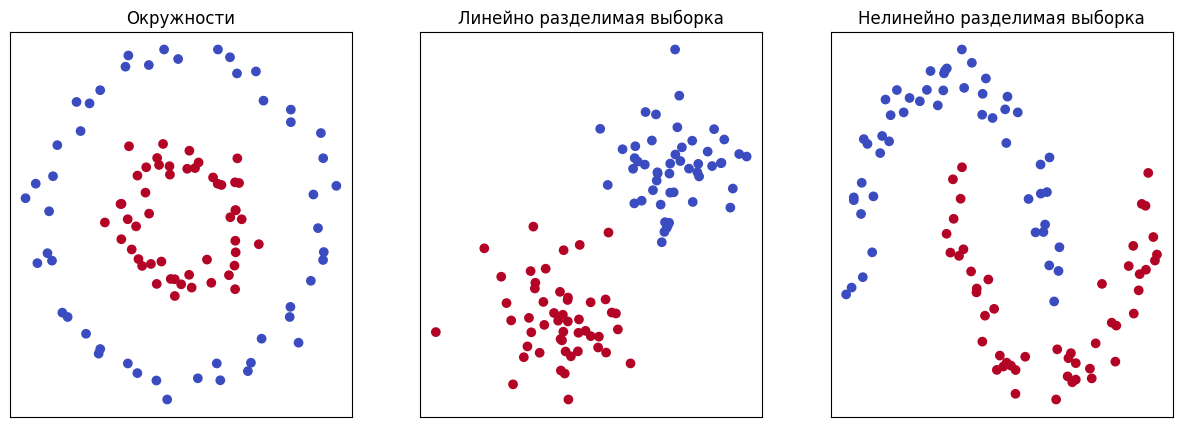

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax[0].set_title('Окружности')
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[0].scatter(X_circle[:, 0], X_circle[:, 1], c=y_circle, cmap=plt.cm.coolwarm)

ax[1].set_title('Линейно разделимая выборка')
ax[1].set_xticks(())
ax[1].set_yticks(())
ax[1].scatter(X_linear[:, 0], X_linear[:, 1], c=y_linear, cmap=plt.cm.coolwarm)

ax[2].set_title('Нелинейно разделимая выборка')
ax[2].set_xticks(())
ax[2].set_yticks(())
ax[2].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=plt.cm.coolwarm)

plt.show()

In [ ]:
class SVMClassifier:
  def __init__(self, kernel, C):
    self.__kernel = kernel # ядро
    self.__C = C # коэффициент допустимых ошибок

    self.__fitted = False

  def predict(self, X):
    if not self.__fitted:
      print("Этот экземпляр еще не обучен, используйте метод fit")
      return


    return np.sign( np.dot(self.__kernel(self.__X_supp, X).T, self.__lagrange_coefs * self.__y_supp) + self.__bias )

  def fit(self, X, y):
    n_samples, n_features = X.shape

    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
       for j in range(n_samples):
           K[i,j] = self.__kernel(X[i].reshape(1, -1), X[j].reshape(1, -1))

    P = cvxopt.matrix(np.outer(y,y) * K)
    q = cvxopt.matrix(np.ones(n_samples) * -1)
    A = cvxopt.matrix(y, (1,n_samples))
    b = cvxopt.matrix(0.0)

    if self.__C is None:
       G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
       h = cvxopt.matrix(np.zeros(n_samples))
    else:
       G = cvxopt.matrix(np.vstack((np.diag(np.ones(n_samples) * -1), np.identity(n_samples))))
       h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.__C)))

    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    self.__lagrange_coefs = np.ravel(solution['x'])

    self.__X_supp = X[self.__lagrange_coefs > 1e-5]
    self.__y_supp = y[self.__lagrange_coefs > 1e-5]
    self.__lagrange_coefs = self.__lagrange_coefs[self.__lagrange_coefs > 1e-5]

    self.__bias = np.mean( self.__y_supp - np.dot(self.__kernel(self.__X_supp, self.__X_supp), self.__lagrange_coefs * self.__y_supp) )

    self.__fitted = True

  def get_support_vectors(self):
    return self.__X_supp, self.__y_supp

  def get_lagrange_coefs(self):
    return self.__lagrange_coefs

  def get_kernel(self):
    return self.__kernel

  def get_bias(self):
    return self.__bias

In [ ]:
linear_clf = SVMClassifier(kernel=linear_kernel, C=1.)
linear_clf.fit(X_linear_train, y_linear_train)

rbf_clf = SVMClassifier(kernel=rbf_kernel, C=5.)
rbf_clf.fit(X_circle_train, y_circle_train)

polynomial_clf = SVMClassifier(kernel=polynomial_kernel, C=.1)
polynomial_clf.fit(X_moons_train, y_moons_train)

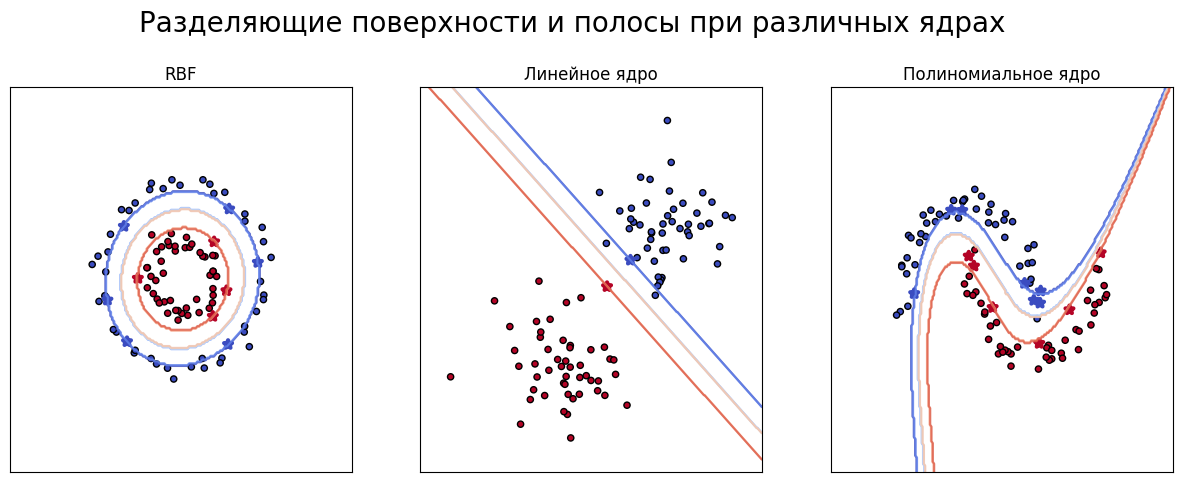

In [ ]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, C=1, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    kernel = clf.get_kernel()
    support_X, support_y = clf.get_support_vectors()
    lagrange_coefs = clf.get_lagrange_coefs()
    bias = clf.get_bias()

    margin = np.mean(np.abs(np.dot(kernel(support_X, support_X).T, lagrange_coefs * support_y) + bias))
    bound_eq_values = np.dot(kernel(support_X, np.c_[xx.ravel(), yy.ravel()]).T, lagrange_coefs * support_y) + bias

    Z = C * Z
    Z[np.logical_and(bound_eq_values <= margin, bound_eq_values > 0)] = .5 * C
    Z[np.logical_and(bound_eq_values >= -margin, bound_eq_values <= 0)] = -.5 * C
    Z = Z.reshape(xx.shape)

    out = ax.contour(xx, yy, Z, **params)
    return out

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# окружности
X0_circle, X1_circle = X_circle[:, 0], X_circle[:, 1]
xx_circle, yy_circle = make_meshgrid(X0_circle, X1_circle)

# линейно разделимая
X0_linear, X1_linear = X_linear[:, 0], X_linear[:, 1]
xx_linear, yy_linear = make_meshgrid(X0_linear, X1_linear)

# нелинейно разделимая
X0_moons, X1_moons = X_moons[:, 0], X_moons[:, 1]
xx_moons, yy_moons = make_meshgrid(X0_moons, X1_moons)

plot_contours(ax[0], rbf_clf, xx_circle, yy_circle, cmap=plt.cm.coolwarm, alpha=0.8)
support_X_rbf, support_y_rbf = rbf_clf.get_support_vectors()
ax[0].scatter(X0_circle, X1_circle, c=y_circle, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax[0].scatter(support_X_rbf[:, 0], support_X_rbf[:, 1], c=support_y_rbf, cmap=plt.cm.coolwarm, marker='*', linewidths=3)
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[0].set_title('RBF')

plot_contours(ax[1], linear_clf, xx_linear, yy_linear, cmap=plt.cm.coolwarm, alpha=0.8)
support_X_linear, support_y_linear = linear_clf.get_support_vectors()
ax[1].scatter(X0_linear, X1_linear, c=y_linear, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax[1].scatter(support_X_linear[:, 0], support_X_linear[:, 1], c=support_y_linear, cmap=plt.cm.coolwarm, marker='*', linewidths=3)
ax[1].set_xticks(())
ax[1].set_yticks(())
ax[1].set_title('Линейное ядро')

plot_contours(ax[2], polynomial_clf, xx_moons, yy_moons, cmap=plt.cm.coolwarm, alpha=0.8)
support_X_unline, support_y_unline = polynomial_clf.get_support_vectors()
ax[2].scatter(X0_moons, X1_moons, c=y_moons, s=20, cmap=plt.cm.coolwarm, edgecolors='k')
ax[2].scatter(support_X_unline[:, 0], support_X_unline[:, 1], c=support_y_unline, cmap=plt.cm.coolwarm, marker='*', linewidths=3)
ax[2].set_xticks(())
ax[2].set_yticks(())
ax[2].set_title('Полиномиальное ядро')

fig.suptitle('Разделяющие поверхности и полосы при различных ядрах', fontsize=20, verticalalignment='bottom')
plt.show()

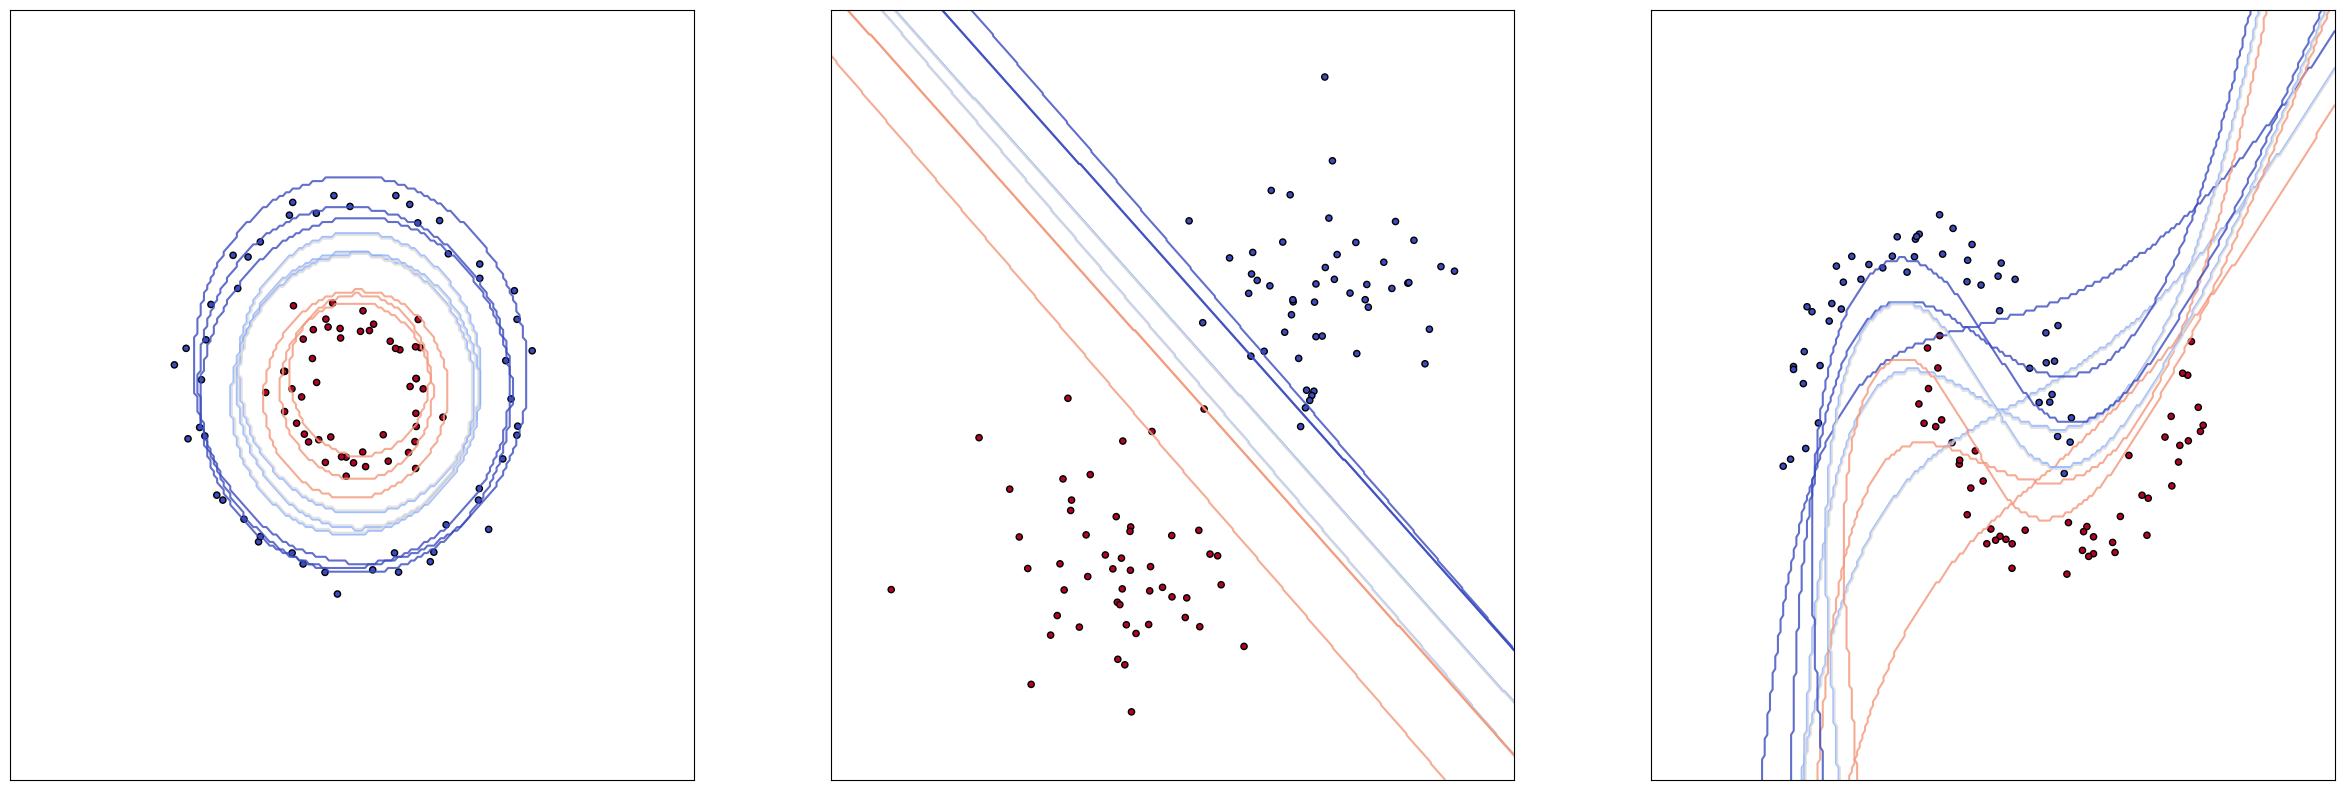

In [ ]:
# влияние параметра C на вид разделяющей полосы
Cs = np.logspace(-1.0, 1.0, 3)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[1].set_xticks(())
ax[1].set_yticks(())
ax[2].set_xticks(())
ax[2].set_yticks(())

# окружности
X0_circle, X1_circle = X_circle[:, 0], X_circle[:, 1]
xx_circle, yy_circle = make_meshgrid(X0_circle, X1_circle)

# линейно разделимая
X0_linear, X1_linear = X_linear[:, 0], X_linear[:, 1]
xx_linear, yy_linear = make_meshgrid(X0_linear, X1_linear)

# нелинейно разделимая
X0_moons, X1_moons = X_moons[:, 0], X_moons[:, 1]
xx_moons, yy_moons = make_meshgrid(X0_moons, X1_moons)

ax[0].scatter(X0_circle, X1_circle, c=y_circle, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax[1].scatter(X0_linear, X1_linear, c=y_linear, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax[2].scatter(X0_moons, X1_moons, c=y_moons, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

rbf_clfs = []
linear_clfs = []
polynomial_clfs = []

for C in Cs:
  rbf_clf = SVMClassifier(C=C, kernel=rbf_kernel)
  linear_clf = SVMClassifier(C=C, kernel=linear_kernel)
  polynomial_clf = SVMClassifier(C=C, kernel=polynomial_kernel)

  rbf_clf.fit(X_circle_train, y_circle_train)
  linear_clf.fit(X_linear_train, y_linear_train)
  polynomial_clf.fit(X_moons_train, y_moons_train)

  rbf_clfs.append(rbf_clf)
  linear_clfs.append(linear_clf)
  polynomial_clfs.append(polynomial_clf)

  cp_rbf = plot_contours(ax[0], rbf_clf, xx_circle, yy_circle, C=C, cmap=plt.cm.coolwarm, alpha=.8, linestyles=['-'], levels=3)
  cp_lin = plot_contours(ax[1], linear_clf, xx_linear, yy_linear, C=C, cmap=plt.cm.coolwarm, alpha=.8, linestyles=['-'], levels=3)
  cp_pol = plot_contours(ax[2], polynomial_clf, xx_moons, yy_moons, C=C, cmap=plt.cm.coolwarm, alpha=.8, linestyles=['-'], levels=3)

plt.show()